In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load thalamus data

In [3]:
obs_wmb = abc.get_combined_metadata()
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [4]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

In [5]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

In [6]:
# Precompute boundaries to use multiple times in this notebook w/o need to recompute

# we only need to load the boundaries for sections that contain the thalamus
sections_all = sorted(obs_th[section_col].unique())
sections_int = np.rint(np.array(sections_all)/0.2).astype(int)

# precompute boundaries for thalamic sections
ccf_boundaries = cimg.sectionwise_label_erosion(ccf_images, distance_px=1, 
                                                fill_val=0, return_edges=True, 
                                                section_list=sections_int
                                                )

In [7]:
# 3 example sections for paper figures
sections_3 = [6.4, 7.2, 8.0]

In [8]:
# if you reload thalamus_merfish_analysis.ccf_plots after this cell has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names('substructure')

In [9]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
# palette_df = pd.read_csv('/code/resources/cluster_palette_glasbey.csv')
cluster_palette = abc.get_thalamus_cluster_palette() #dict(zip(palette_df['Unnamed: 0'], palette_df['0']))

ccf_palette = abc.get_ccf_palette('substructure')
ccf_palette['ZI'] = ccf_palette.pop('ZI-unassigned') # need to fix a key error

## Figure 1: Thalamic cell types vs anatomical annotations

### Figure 1(a): Subset of ABC Atlas

/root/capsule/code/thalamus_merfish_analysis/ccf_plots.py:906: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  obs = pd.concat(


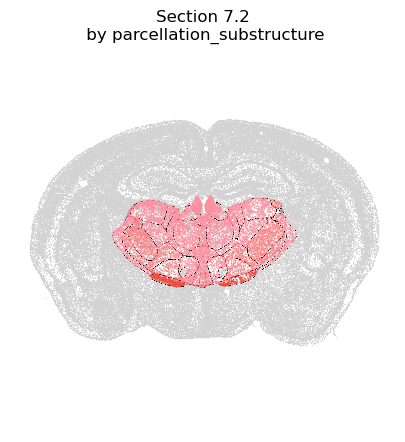

In [10]:
kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=obs_wmb, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='black',
                        point_size=1, # cell marker size
                       )

taxonomy_level = 'class'
class_figs= cplots.plot_ccf_overlay(
    obs_th, 
    ccf_images, 
    point_hue='parcellation_substructure',
    sections=[sections_3[1]],
    separate_figs=True, # False does NOT show bg_cells
    point_palette=ccf_palette,#abc_palettes[taxonomy_level],
    legend=None, #'cells',
    figsize=(20, 5),
    custom_xy_lims=[0, 11, 11, 0],
    **kwargs_celltypes
)

### Figure 1(b): Taxonomy tree

### Figure 1(c): ARA anatomical annotations 

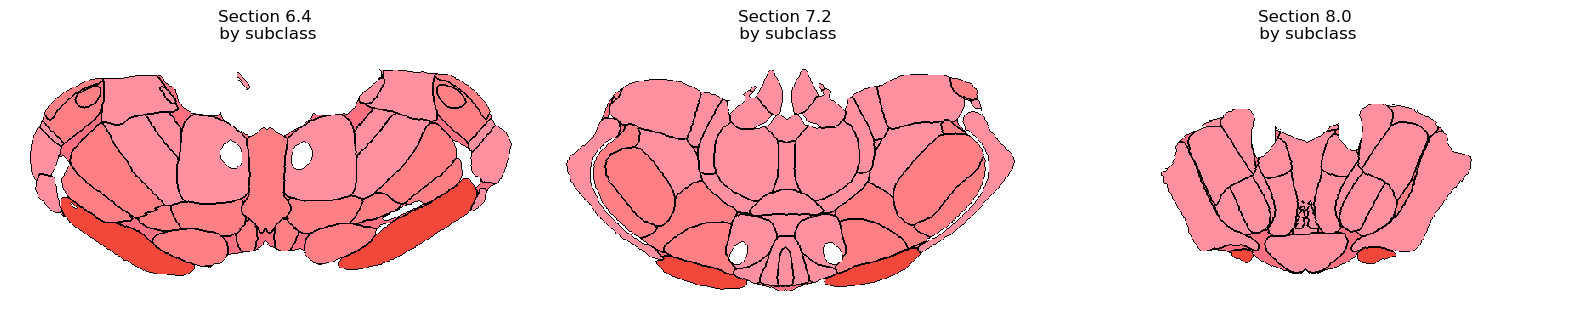

In [11]:
kwargs = dict(
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=0,
    edge_color="black",
    boundary_img=ccf_boundaries,
    # custom_xy_lims=[2.5, 6, 7, 4],
)

figs = cplots.plot_ccf_overlay(
    obs_th,
    ccf_images,
    point_hue="subclass",
    face_palette=ccf_palette, 
    min_group_count=0,
    sections=sections_3,
    separate_figs=False,
    figsize=(20, 5),
    legend=None,
    **kwargs,
)
# fig.savefig(f'../results/spaGCN_domains_ccf_overlay_3sections_res{res_str}.pdf', 
#             transparent=True, bbox_inches='tight')

### Figure 1(d-g): TH+ZI cell types

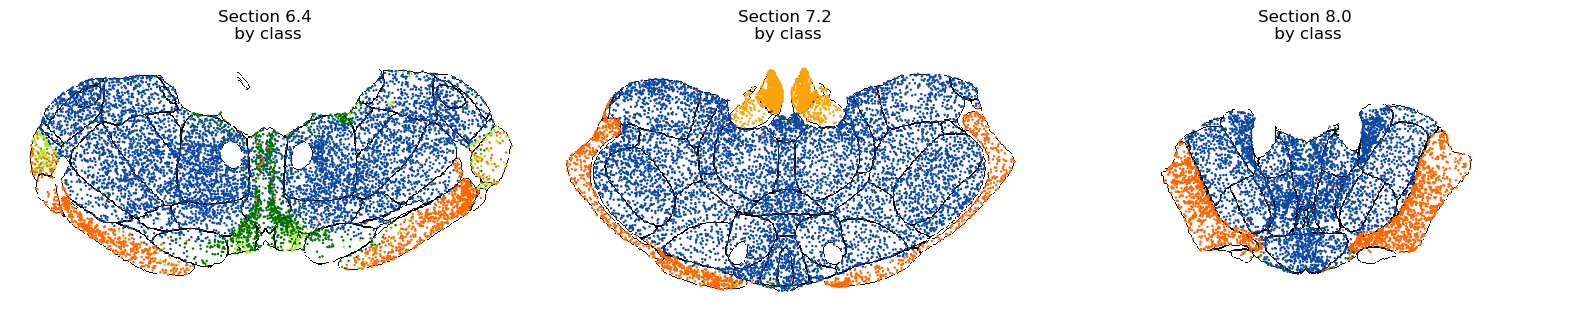

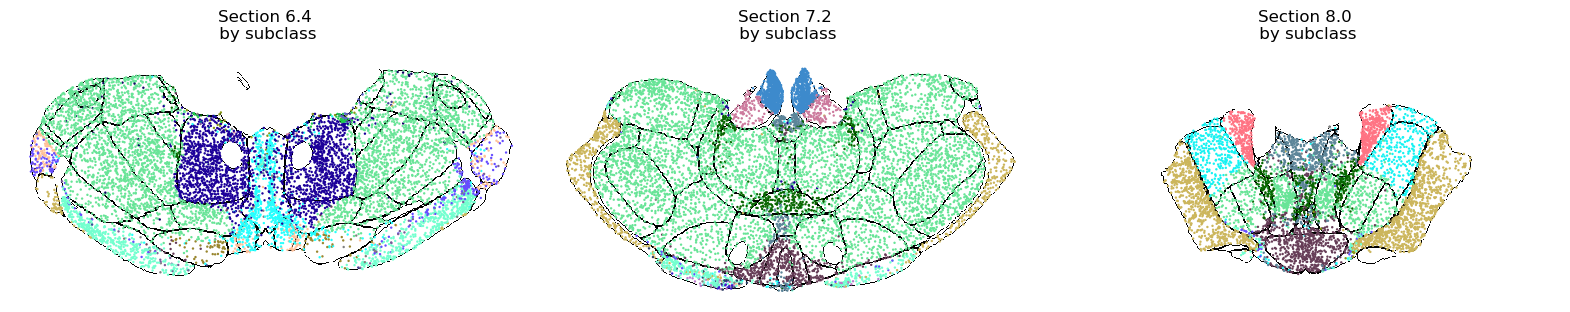

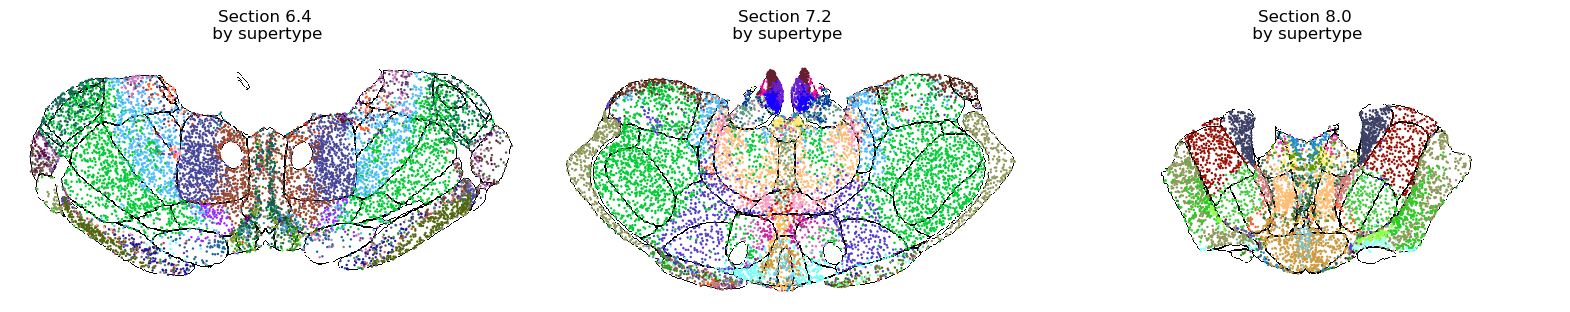

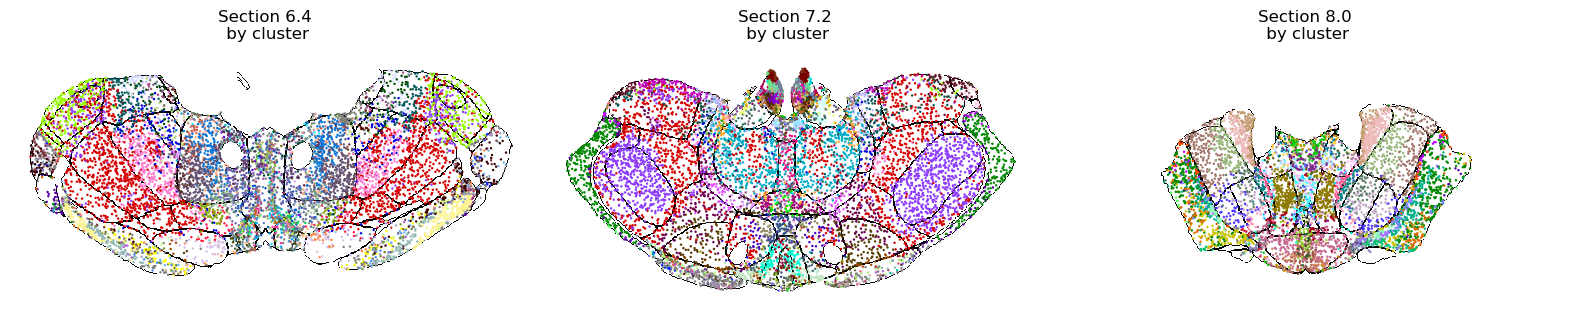

In [12]:
kwargs_celltypes = dict(boundary_img=ccf_boundaries,
                        bg_cells=None,#obs_wmb, # background cells are displayed in grey
                        section_col=section_col,
                        x_col=x_col, 
                        y_col=y_col,
                        edge_color='black',
                        point_size=3, # cell marker size
                       )

levels = ['class', 'subclass', 'supertype', 'cluster']

for taxonomy_level in levels:
    if taxonomy_level == 'cluster':
        palette = cluster_palette
    else:
        palette = abc_palettes[taxonomy_level]
        
    nt_figs = cplots.plot_ccf_overlay(
        obs_th, 
        ccf_images, 
        point_hue=taxonomy_level, 
        sections=sections_3,
        separate_figs=False,
        point_palette=palette,
        legend=None, #'cells',
        figsize=(20, 5),
        **kwargs_celltypes
    )

## Table 1: Taxonomy for TH+ZI cell types

In [13]:
taxonomy_levels = ['class', 'subclass', 'supertype', 'cluster']
obs_tax = obs_th.drop_duplicates(subset='cluster')[taxonomy_levels]

# Clean up the taxonomy columns for sorting
for col in obs_tax.columns:
    # only keep categories that are present in the TH+ZI dataset
    obs_tax.loc[:,col] = obs_tax.loc[:,col].cat.remove_unused_categories()
    # remove leading/trailing whitespace
    obs_tax.loc[:,col] = obs_tax.loc[:,col].str.strip()
    # extract the ID # b/c lexically sorting the str object doesn't yield correct order
    obs_tax.loc[:,col+'_id'] = obs_tax.loc[:,col].str.extract('(\d+)', expand=False).astype(float)

# sort by ID #s
num_cols = [x+'_id' for x in taxonomy_levels]
taxonomy_df = obs_tax.sort_values(by=num_cols, ascending=True, ignore_index=True)
# clean up the ID columns
taxonomy_df = taxonomy_df.drop(columns=num_cols)

display(taxonomy_df)

,class,subclass,supertype,cluster
0,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1580 RT-ZI Gnb3 Gaba_1
1,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1581 RT-ZI Gnb3 Gaba_1
2,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1582 RT-ZI Gnb3 Gaba_1
3,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1583 RT-ZI Gnb3 Gaba_1
4,12 HY GABA,093 RT-ZI Gnb3 Gaba,0431 RT-ZI Gnb3 Gaba_1,1584 RT-ZI Gnb3 Gaba_1
...,...,...,...,...
558,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3802 SCsg Gabrr2 Gaba_1
559,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3803 SCsg Gabrr2 Gaba_1
560,20 MB GABA,213 SCsg Gabrr2 Gaba,0872 SCsg Gabrr2 Gaba_1,3804 SCsg Gabrr2 Gaba_1
561,20 MB GABA,213 SCsg Gabrr2 Gaba,0873 SCsg Gabrr2 Gaba_2,3808 SCsg Gabrr2 Gaba_2


In [14]:
# Save out as csv file
taxonomy_df.to_csv('../results/th_zi_taxonomy_CCN20230722.csv', index=False)

## Figure 2: Thalamic nuclei metrics

In [15]:
from thalamus_merfish_analysis import ccf_erode as cerd
from thalamus_merfish_analysis import diversity_metrics as divmet
from thalamus_merfish_analysis import diversity_plots as dplot

In [16]:
obs_erode = cerd.label_cells_by_eroded_ccf(obs_th, ccf_images) # default is erosion by 5px (5um)
# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure

obs_erode.loc[lambda df: df['z_section']==6.6, cerd.ERODED_CCF_STRUCTURE_COL] = 'unassigned'

# generate metrics for the eroded CCF structure
ccf_label='parcellation_structure_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)

regions_to_plot = dplot.TH_DIVERSITY_REGIONS

### Fig 2(?): Stacked barplots

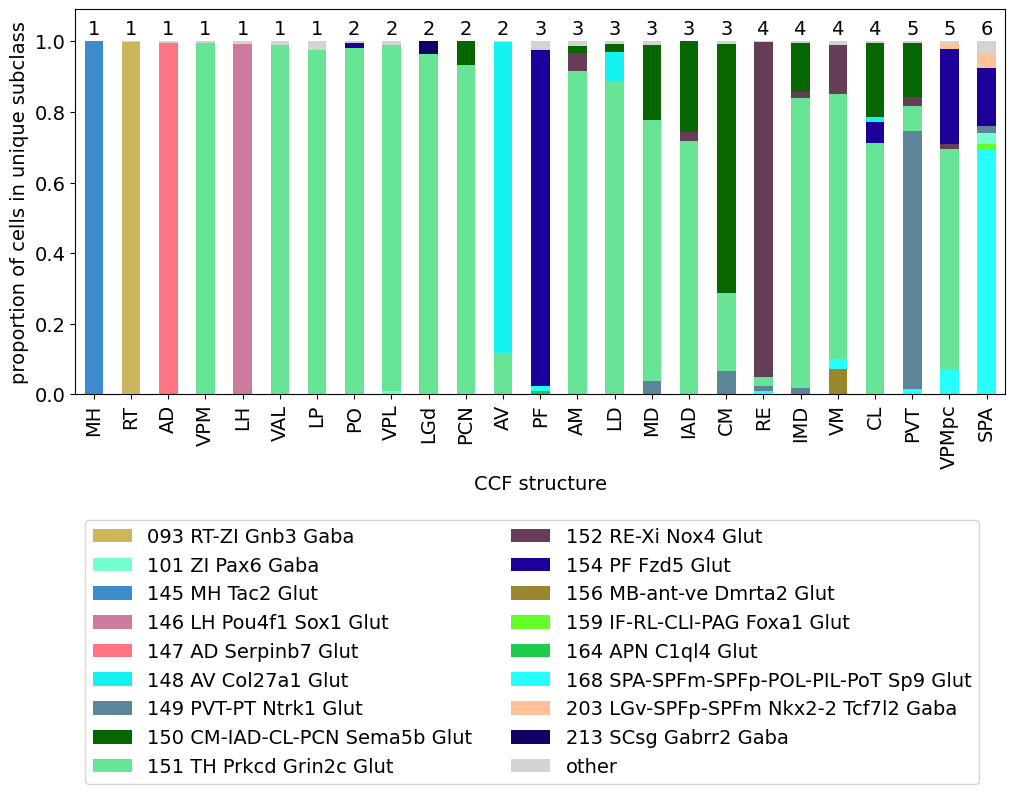

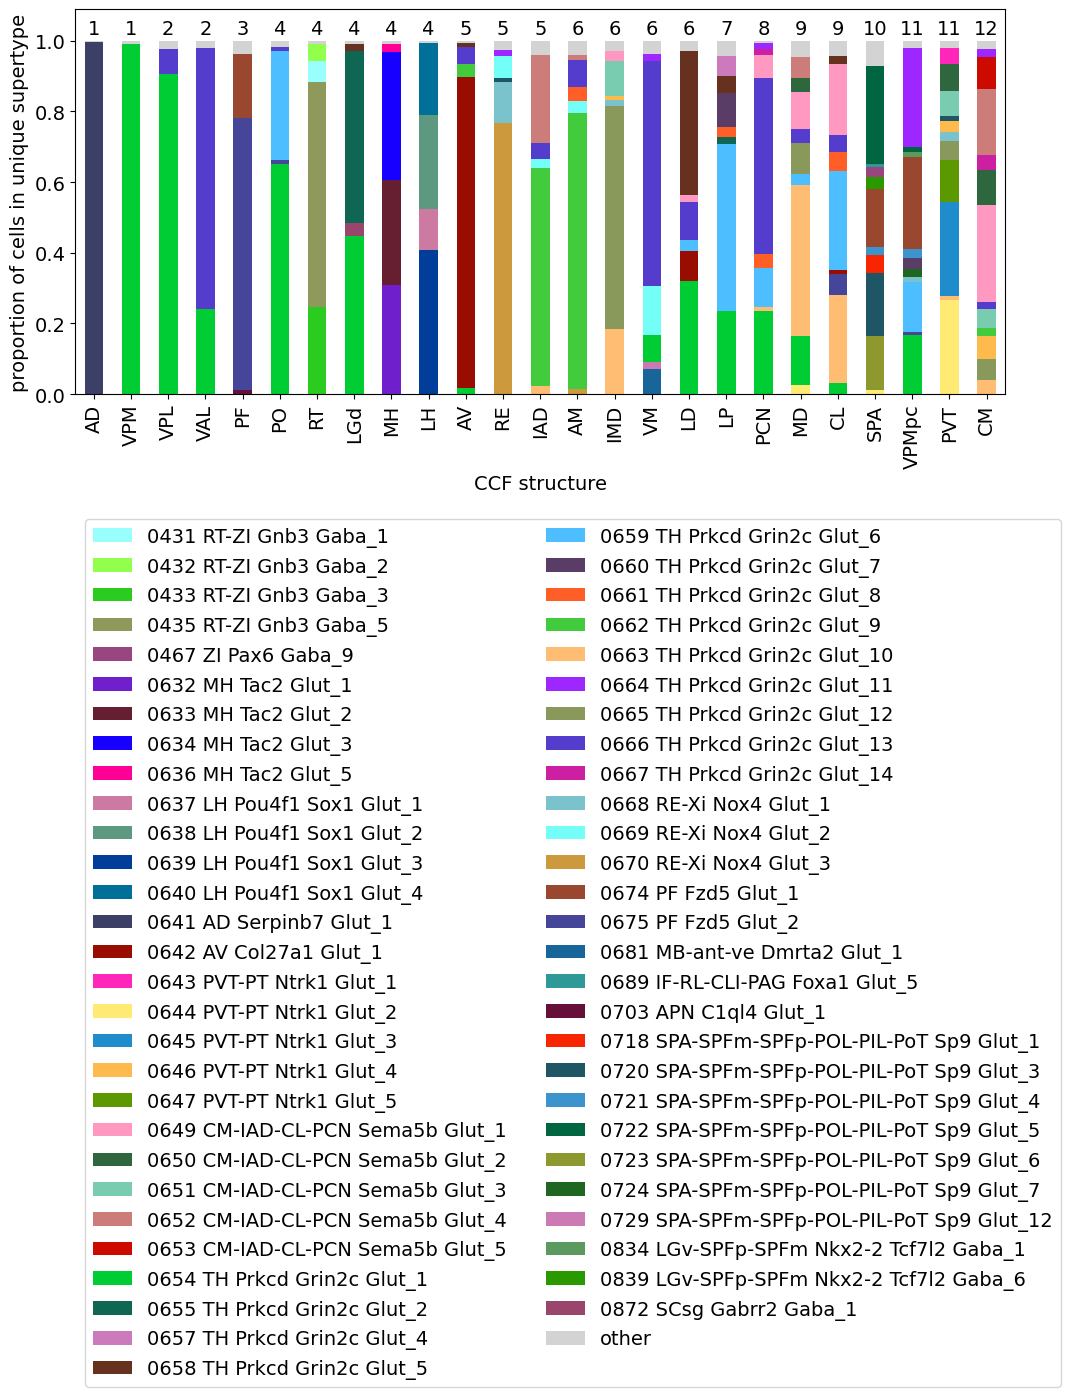

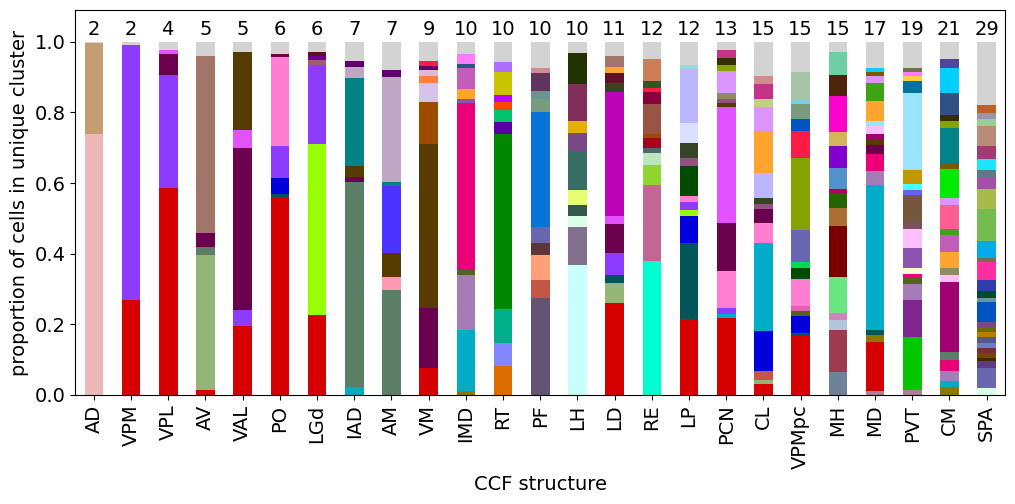

In [23]:
# subclass
fig_bp_subclass = dplot.barplot_stacked_proportions(
    obs_erode, 
    'subclass', 
    th_ccf_metrics, 
    legend=True, 
    min_cell_frac=0.01  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
)

# supertype
fig_bp_subclass = dplot.barplot_stacked_proportions(
    obs_erode, 
    'supertype', 
    th_ccf_metrics, 
    legend=True, 
    min_cell_frac=0.01  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
)

# cluster
fig_bp_subclass = dplot.barplot_stacked_proportions(
    obs_erode, 
    'cluster', 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
)

### Fig 2(?): 2D heatmaps

In [24]:
import thalamus_merfish_analysis.distance_metrics as dm

In [ ]:
# TODO: 2D heatmaps of nuclei vs taxonomy level categories (like for SpaGCN domains)